In [350]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

## Data Load (using WFDB)

MIT-BIH Dataset은 Train data와 Annotation이 존재, 따라서 Annotation에 맞는 window를 설정

In [351]:
# Data Extract From Physionet *.dat

input_path = "../physionet/mit-bih_arr/1.0.0/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
    records_list.append(l)
records.close()
print(records_list)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [352]:
NORMAL_ANN = ['N', 'L', 'R']
SUPRA_ANN = ['e',"j","A","a","J","S"]
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

In [417]:
window_size = 320

# Ref : Heartbeat classification fusing temporal and morphological information of ECGs via ensemble of classifiers
NORMAL_ANN = ['N', 'L', 'R']
SUPRA_ANN = ['e',"j","A","a","J","S"]
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

ANN_DICT = {0:"N", 1:"S", 2:"V", 3:"F", 4:"Q", 5:"-"}

def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=sampfrom, sampto = sampto)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto).sample)[1:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto).symbol)[1:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)
    
    """
    0 : N | 1 : S | 2 : V | 3 : F | 4 : Q
    """
    for i,sym in enumerate(record_ann_sym):
        if sym in NORMAL_ANN:
            record_ann_sym[i] = 0
        elif sym in SUPRA_ANN:
            record_ann_sym[i] = 1
        elif sym in VENTRI_ANN:
            record_ann_sym[i] = 2
        elif sym in FUSION_ANN:
            record_ann_sym[i] = 3
        elif sym in UNCLASS_ANN:
            record_ann_sym[i] = 4
        else:
            record_ann_sym[i] = 5
    
#     zorder=2
#     def draw_circle_with_annotation(ax, position, label):
#         nonlocal zorder
#         point = patches.Circle(position, picker=True, edgecolor="r", zorder=zorder, radius=0.25, facecolor="none")
#         ax.add_patch(point)
#         zorder+=1
    return record_sig, record_ann, record_ann_sym
    
    
#     scaler.fit(record_sig)

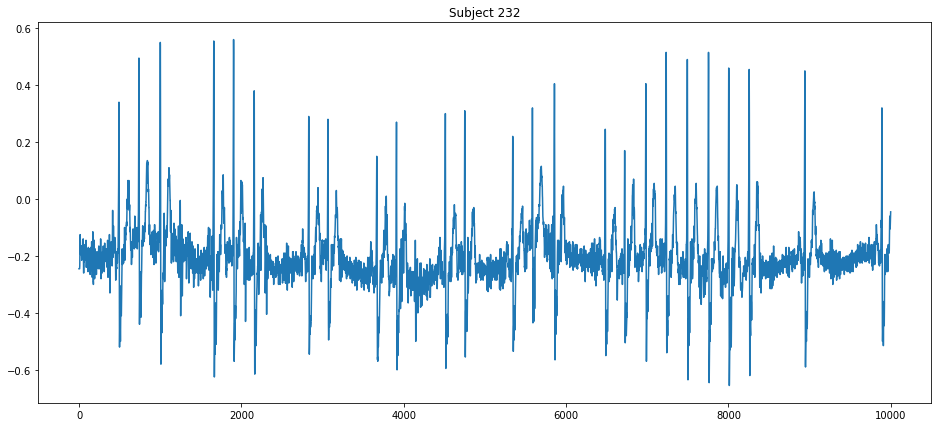

In [452]:
idx = 45
sampfrom= 0
sampto = 10000
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx, sampfrom, sampto)
%matplotlib INLINE
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(record_sig[0][0:10000])
#     draw_circle_with_annotation(ax1, (record_ann[0],record_sig[0][record_ann[0]]), ANN_DICT[record_ann_sym[0]])
# ax1.annotate(text=ANN_DICT[record_ann_sym[0]], xy=(record_ann[0],record_sig[0][record_ann[0]]),fontsize=15,ha="center")
# ax1.annotate(text=ANN_DICT[record_ann_sym[1]], xy=(record_ann[1],record_sig[0][record_ann[1]]),fontsize=15,ha="center")
plt.show()

In [425]:
# Beat Segment (Visualization)

# Beat Segement Points = median(prev_Rpeak, now_Rpeak) ~ median(now_Rpeak, next_Rpeak)
seg_points = []

"""
첫 rpeak는 next_Rpeak랑만 계산
"""
l_ann = len(record_ann)
last_points = len(record_sig[0])-1

N_Sig = []
S_Sig = []
V_Sig = []
F_Sig = []
Q_Sig = []

for i in range(l_ann):
    
    now_r = record_ann[i]
    now_sym = (ANN_DICT[record_ann_sym[i]],record_ann_sym[i])
    if now_sym[0] == "-":
        continue
    if i == 0: # 첫번째 예외처리
        next_r = record_ann[i+1]
        next_points = (next_r + now_r) // 2
        prev_points = 0
    elif i == l_ann-1: #마지막 예외처리
        prev_r = record_ann[i-1]
        prev_points = (prev_r + now_r) // 2
        next_points = last_points
    else: 
        prev_r = record_ann[i-1]
        next_r = record_ann[i+1]

        prev_points = (prev_r+now_r)//2
        next_points = (next_r+now_r)//2
    
    
#     print(prev_points, next_points, "Size :", (next_points-prev_points), now_sym)
    # Beat Segmentation
    if now_sym[0] == "N":
        N_Sig.append([prev_points,next_points])
    elif now_sym[0] == "S":
        S_Sig.append([prev_points,next_points])  
    elif now_sym[0] == "V":
        V_Sig.append([prev_points,next_points])
    elif now_sym[0] == "F":
        F_Sig.append([prev_points,next_points])
    elif now_sym[0] == "Q":
        Q_Sig.append([prev_points,next_points])
    
    
    

In [426]:
N_Sig = []
S_Sig = []
V_Sig = []
F_Sig = []
Q_Sig = []
def extract_Beats(record_ann,record_sig, record_ann_sym):
    global N_Sig, S_Sig, V_Sig, F_Sig, Q_Sig
    # Beat Segement Points = median(prev_Rpeak, now_Rpeak) ~ median(now_Rpeak, next_Rpeak)
    seg_points = []
    l_ann = len(record_ann)
    last_points = len(record_sig[0])-1
    max_len = -1
    min_len = 9999
    for i in range(l_ann):

        now_r = record_ann[i]
        now_sym = (ANN_DICT[record_ann_sym[i]],record_ann_sym[i])
        if now_sym[0] == "-":
            continue
        if i == 0: # 첫번째 예외처리
            next_r = record_ann[i+1]
            next_points = (next_r + now_r) // 2
            prev_points = 0
        elif i == l_ann-1: #마지막 예외처리
            prev_r = record_ann[i-1]
            prev_points = (prev_r + now_r) // 2
            next_points = last_points
        else: 
            prev_r = record_ann[i-1]
            next_r = record_ann[i+1]

            prev_points = (prev_r+now_r)//2
            next_points = (next_r+now_r)//2

#         print(prev_points, next_points, "Size :", (next_points-prev_points), now_sym)
        max_len = max(max_len, next_points-prev_points)
        min_len = min(min_len, next_points-prev_points)
        # Beat Segmentation
        if now_sym[0] == "N":
            N_Sig.append(record_sig[0][prev_points:next_points])
        elif now_sym[0] == "S":
            S_Sig.append(record_sig[0][prev_points:next_points])  
        elif now_sym[0] == "V":
            V_Sig.append(record_sig[0][prev_points:next_points])
        elif now_sym[0] == "F":
            F_Sig.append(record_sig[0][prev_points:next_points])
        elif now_sym[0] == "Q":
            Q_Sig.append(record_sig[0][prev_points:next_points])

### Visualization MIT-BIH Data Annotation N,S,V,F,Q

In [437]:
for idx in range(len(records_list)):
    record_sig, record_ann, record_ann_sym = extract_from_sbj(idx,0,650000)
    extract_Beats(record_ann,record_sig,record_ann_sym)
#     print("Complete_idx:",idx)

In [438]:
print(len(N_Sig))
print(len(S_Sig))
print(len(V_Sig))
print(len(F_Sig))
print(len(Q_Sig))

185062
6112
14760
1633
16491


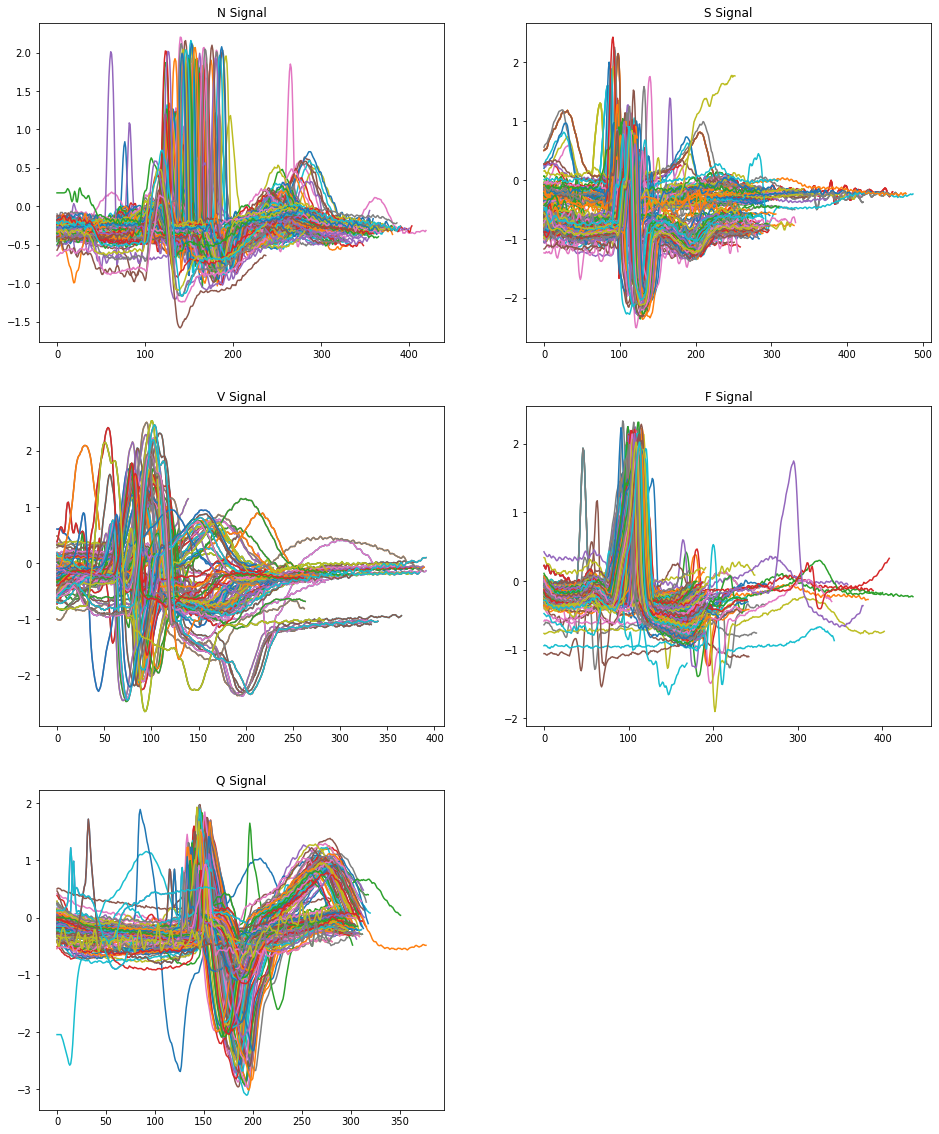

In [450]:
%matplotlib INLINE
# Visualization N,S,F,V,Q
fig = plt.figure(figsize=(16,20))

target = 200

ax1 = fig.add_subplot(3,2,1)
ax1.set_title("N Signal")
count = 0
for sigs in N_Sig:
    if count == target:
        break
    ax1.plot(sigs)
    count+=1

ax2 = fig.add_subplot(3,2,2)
ax2.set_title("S Signal")
count = 0
for sigs in S_Sig:
    if count == target:
        break
    ax2.plot(sigs)
    count+=1
    
ax3 = fig.add_subplot(3,2,3)
ax3.set_title("V Signal")
count = 0
for sigs in V_Sig:
    if count == target:
        break
    ax3.plot(sigs)
    count+=1

ax4 = fig.add_subplot(3,2,4)
ax4.set_title("F Signal")
count = 0
for sigs in F_Sig:
    if count == target:
        break
    ax4.plot(sigs)
    count+=1

ax5 = fig.add_subplot(3,2,5)
ax5.set_title("Q Signal")
count = 0
for sigs in Q_Sig:
    if count == target:
        break
    ax5.plot(sigs)
    count+=1

### Visualization MIT-BIH ECG Data with Annotation

Bokeh라는 새로운 Visualization Library로 Annotation을 Visualization 함


In [483]:
idx = 45
sampfrom= 0
sampto = 70000
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx, sampfrom, sampto)

#### BOKEH

In [478]:
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.resources import INLINE
output_notebook(INLINE)

Loading BokehJS ...

In [442]:
np.squeeze(np.array(record_sig[0]),axis=1)

array([-0.245, -0.245, -0.245, ..., -0.07 , -0.065, -0.045])

In [447]:
x_data = np.squeeze(np.array(record_sig[0]),axis=1)
x_data_len = len(x_data)

# record_ann : ann x_location
# record_ann_sym : ann Symbol

y_data = ["" for _ in range(x_data_len)]
for i,sym_loc in enumerate(record_ann):
    y_data[sym_loc] = ANN_DICT[record_ann_sym[i]]
    print(ANN_DICT[record_ann_sym[i]], end=" ")

N S S N S S - N S N S N S N S S N S S S S S S S N N 

In [446]:
source = ColumnDataSource(data=dict(height=x_data,
                                    weight=[x for x in range(x_data_len)],
                                    symbols=y_data))
fig = figure(title="Subject {}".format(records_list[idx]),width=900,height=400, x_range= Range1d(sampfrom,sampto))
fig.line(x="weight", y="height", source=source, line_width=2, color="green")
labels = LabelSet(x="weight",y= "height", text="symbols", x_offset=5, y_offset=5, source=source, text_font_size="8px")

fig.xaxis[0].axis_label = "Time(ms)"
fig.yaxis[0].axis_label = "Voltage(mV)"

fig.add_layout(labels)

show(fig)

#### Matplotlib Notebook

<IPython.core.display.Javascript object>


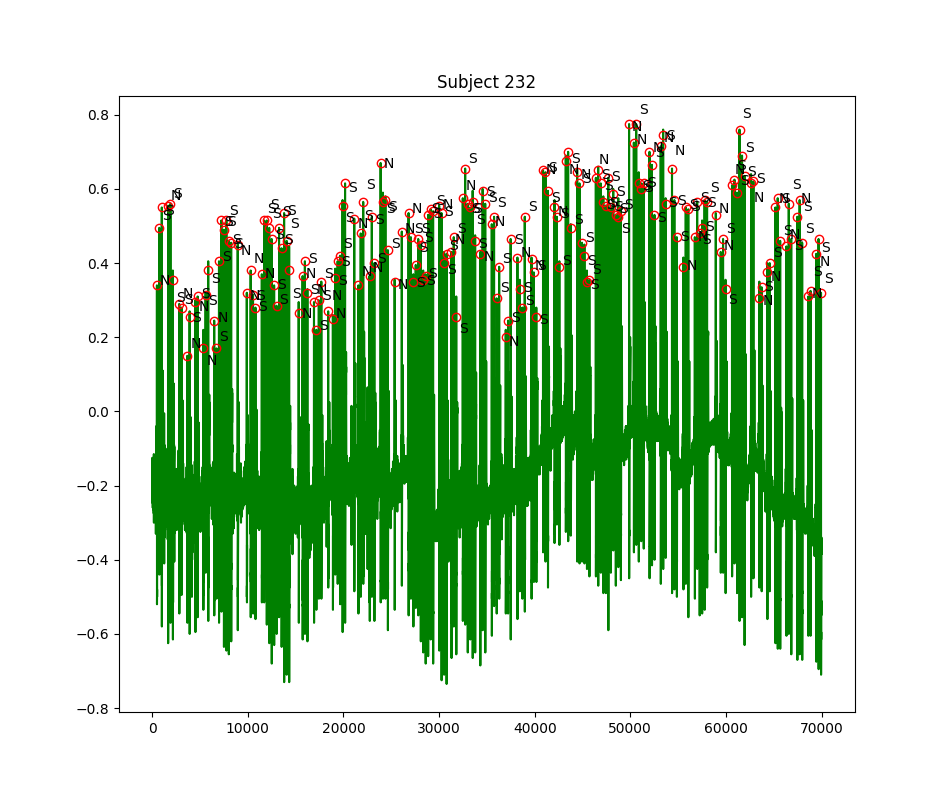

In [496]:
%matplotlib notebook

#record_ann_sym , Record위치에 있는 심볼
#record_ann , Record위치

fig = plt.figure(figsize=(9.5,8))
ax_ann = fig.add_subplot(1,1,1)
ax_ann.set_title("Subject {}".format(records_list[idx]))
ax_ann.plot(x_data,color="green")

x_data = np.squeeze(np.array(record_sig[0]),axis=1)
x_data_len = len(x_data)

for i,x_location in enumerate(record_ann):
    if record_ann_sym[i] == 5:
        continue
    ax_ann.annotate(ANN_DICT[record_ann_sym[i]], xy=(x_location,x_data[x_location]),
                    xycoords="data", textcoords="offset pixels", xytext=(3,17))

record_ann_x = [x_location+1 for i,x_location in enumerate(record_ann) if record_ann_sym[i]!=5]
record_ann_v = [x_data[x_location] for x_location in record_ann_x]
ax_ann.plot(record_ann_x, record_ann_v, "ro", linewidth=2, fillstyle="none")

fig.show()

"""
x_location+1 을 해주는 이유는 Data자체가 Matlab 기반인 것 같음, 따라서 index를 맞춰준 것.
"""


Beat Padding에서 패딩 영역을 0으로 처리하는 것이 아니라 처음과 마지막 값을 그대로 이어가야하는 것이 아닐까 싶음

길이가 긴 R peak의 경우에는..

### MIT BIH Data baseline Normalization